In [1]:
import matplotlib.pyplot as plt
import hopsy
import os
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit
from PolyRound.api import PolyRoundApi

In [2]:
class Boltzman_Modell:
    def __init__(self, beta, index):
        self.beta = beta
        self.index = index
        
    def compute_negative_log_likelihood(self, x):
        print('x', x.shape)
        return - beta @ x[self.index]

In [3]:
model_path = os.path.join("models", "e_coli_core.xml")

In [4]:
raw_polytope = PolyRoundApi.sbml_to_polytope(model_path)
biomass_index = raw_polytope.A.columns.tolist().index('BIOMASS_Ecoli_core_w_GAM')
glucose_uptake_index = raw_polytope.A.columns.tolist().index('EX_glc__D_e')
polytope = PolyRoundApi.simplify_transform_and_round(raw_polytope)

uniform = hopsy.Problem(A=polytope.A, b=polytope.b, transformation=polytope.transformation, shift=polytope.shift)
starting_point = hopsy.compute_chebyshev_center(uniform)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-30


In [5]:
problems = {
    'uniform': uniform,
    # 'beta=0': uniform_2,  TODO
    # 'beta=10': boltzmann_1, TODO
    # 'beta=-10': boltzmann_2, TODO
    }

In [6]:
rhat = {}
ess = {}
samples = {}
acceptance_rate = {}
n_chains = 4 
n_samples = 10000
thinning = 10

for p, v in problems.items():
    print(p)
    proposal = hopsy.UniformCoordinateHitAndRunProposal(v, starting_point=starting_point)
    mcs = [hopsy.MarkovChain(problem=v, proposal=proposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(i) for i in range(n_chains)]
    acceptance_rate[p], samples[p] = hopsy.sample(mcs, rngs, n_samples=n_samples, thinning=thinning, n_procs=1)
    ess[p] = hopsy.ess(samples[p])
    print('\tess', np.min(ess[p]))
    rhat[p] = hopsy.rhat(samples[p])
    print('\trhat', np.max(rhat[p]))

uniform
	ess 941.5445543911931
	rhat 1.0063495848528252


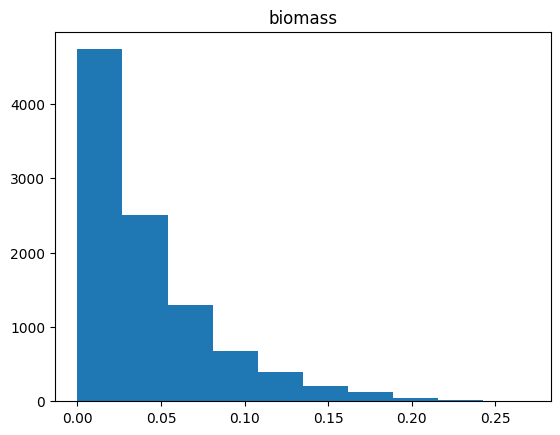

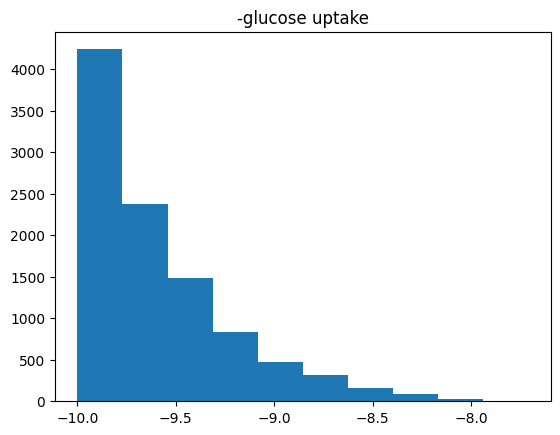

In [7]:
plt.title('biomass')
plt.hist(samples['uniform'][0, :, biomass_index])
# TODO
# plt.hist(samples['beta=0'][0, :, biomass_index])
# plt.hist(samples['beta=10'][0, :, biomass_index])
# plt.hist(samples['beta=-10'][0, :, biomass_index])
plt.show()
plt.title('-glucose uptake')
plt.hist(samples['uniform'][0, :, glucose_uptake_index])
# TODO
# plt.hist(samples['beta=0'][0, :, glucose_uptake_index])
# plt.hist(samples['beta=10'][0, :, glucose_uptake_index])
# plt.hist(samples['beta=-10'][0, :, glucose_uptake_index])
plt.show()